# Milky Way Analysis: Astronomical Validity Verification

This notebook consolidates the results from `01_band_analysis.ipynb` and `02_dark_morphology.ipynb` to perform an integrated astronomical validity check for the smartphone-based Milky Way observation.

We will:
- Load the summary outputs from both analyses
- Cross-validate stellar detection, morphology, and extinction metrics
- Compute a consolidated validity score with transparent criteria
- Produce plots and tables that document the verification outcome

In [1]:
# === Setup and Data Loading ===
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import dedent

# Configure plots
plt.style.use("seaborn-v0_8-darkgrid")

ROOT = Path("..").resolve()
BAND_RESULTS = ROOT / "outputs" / "band_analysis" / "results"
DARK_RESULTS = ROOT / "outputs" / "dark_morphology" / "results"

print(f"Band analysis results directory: {BAND_RESULTS}")
print(f"Dark morphology results directory: {DARK_RESULTS}")

# Helper utilities

def load_json(path: Path):
    with open(path, "r") as f:
        return json.load(f)

# Load required datasets
band_complete = load_json(BAND_RESULTS / "complete_analysis_summary.json")
band_detection = load_json(BAND_RESULTS / "detection_summary.json")
dark_summary = load_json(DARK_RESULTS / "dark_morphology_summary.json")
dark_improved = load_json(DARK_RESULTS / "improved_dark_detection.json")
star_quality = load_json(DARK_RESULTS / "star_detection_quality.json")

print("Loaded summaries:")
for label, payload in {
    "Band Complete": band_complete,
    "Band Detection": band_detection,
    "Dark Summary": dark_summary,
    "Dark Improved": dark_improved,
    "Star Quality": star_quality,
}.items():
    print(f"  - {label}: keys={list(payload.keys())[:5]}...")

Band analysis results directory: /Users/linda/Documents/Amanogawa/outputs/band_analysis/results
Dark morphology results directory: /Users/linda/Documents/Amanogawa/outputs/dark_morphology/results
Loaded summaries:
  - Band Complete: keys=['image_info', 'nearest_neighbor', 'fractal_dimension', 'two_point_correlation']...
  - Band Detection: keys=['image', 'width_px', 'height_px', 'num_stars_detected', 'mean_radius_px']...
  - Dark Summary: keys=['fractal_dimension_dark_mask', 'fractal_dimension_skeleton', 'dark_area_fraction', 'num_dark_components', 'largest_component_area_px']...
  - Dark Improved: keys=['detection_method', 'fractal_dimension_dark_mask', 'fractal_dimension_skeleton', 'dark_area_fraction_original', 'dark_area_fraction_improved']...
  - Star Quality: keys=['total_detections', 'mean_snr', 'high_quality_fraction', 'mean_radius_px', 'spatial_clustering_ratio']...


## Data Sources Overview

The validation draws on the persisted summaries exported by the first two analysis notebooks:

| Source Notebook | Key Files | Content |
| --- | --- | --- |
| `01_band_analysis.ipynb` | `complete_analysis_summary.json`, `detection_summary.json` | Stellar counts, spatial statistics, fractal metrics |
| `02_dark_morphology.ipynb` | `dark_morphology_summary.json`, `improved_dark_detection.json`, `star_detection_quality.json` | Dust lane morphology, improved segmentation, SNR diagnostics |

All files reside under the `outputs/` directory so this notebook can run without reprocessing the raw image.

In [6]:
# === Consolidated Metric Tables ===
record = {}

record["image_dimensions"] = {
    "width_px": band_complete["image_info"]["width_px"],
    "height_px": band_complete["image_info"]["height_px"],
    "total_pixels": band_complete["image_info"]["width_px"] * band_complete["image_info"]["height_px"]
}

record["stellar_detection"] = {
    "band_star_count": band_detection["num_stars_detected"],
    "dark_star_count": star_quality["total_detections"],
    "mean_snr": star_quality.get("mean_snr"),
    "high_quality_fraction": star_quality.get("high_quality_fraction")
}

record["fractal_dimensions"] = {
    "stars_band": band_complete["fractal_dimension"],
    "stars_dark": dark_summary["fractal_dimension_stars"],
    "dark_mask": dark_improved["fractal_dimension_dark_mask"],
    "dark_skeleton": dark_improved["fractal_dimension_skeleton"]
}

record["geometry"] = {
    "bulge_axis_ratio": dark_summary["bulge_axis_ratio"],
    "bulge_principal_axis_deg": dark_summary["bulge_principal_axis_deg"],
    "clustering_scale_px": band_complete["two_point_correlation"]["clustering_scale"]
}

record["dark_components"] = {
    "original_components": dark_improved["num_dark_components_original"],
    "improved_components": dark_improved["num_dark_components_improved"],
    "largest_component_px": dark_improved["component_areas_improved"][-1],
    "mean_eccentricity": dark_improved["mean_eccentricity"],
    "mean_elongation": dark_improved["mean_elongation"],
    "dark_area_fraction": dark_improved["dark_area_fraction_improved"],
}

summary_table = (
    pd.DataFrame(record)
    .rename_axis("metric")
    .reset_index()
)

summary_table

,metric,image_dimensions,stellar_detection,fractal_dimensions,geometry,dark_components
0,width_px,3024.0,NaN,NaN,NaN,NaN
1,height_px,4032.0,NaN,NaN,NaN,NaN
2,total_pixels,12192768.0,NaN,NaN,NaN,NaN
3,band_star_count,NaN,13733.000000,NaN,NaN,NaN
4,dark_star_count,NaN,13733.000000,NaN,NaN,NaN
5,mean_snr,NaN,6.259471,NaN,NaN,NaN
6,high_quality_fraction,NaN,0.818000,NaN,NaN,NaN
7,stars_band,NaN,NaN,1.672392,NaN,NaN
8,stars_dark,NaN,NaN,1.672392,NaN,NaN
9,dark_mask,NaN,NaN,1.986123,NaN,NaN


In [7]:
# === Consistency Checks ===
checks = []

# Star count agreement
band_count = record["stellar_detection"]["band_star_count"]
dark_count = record["stellar_detection"]["dark_star_count"]
star_delta = abs(band_count - dark_count)
star_delta_pct = star_delta / ((band_count + dark_count) / 2)

checks.append({
    "category": "Stellar detection",
    "metric": "Star count agreement",
    "value": star_delta_pct,
    "threshold": 0.10,
    "criterion": "|Δ| / mean < 0.10",
    "passed": star_delta_pct < 0.10,
})

# SNR and quality fraction
checks.append({
    "category": "Stellar detection",
    "metric": "Mean SNR",
    "value": record["stellar_detection"]["mean_snr"],
    "threshold": 5.0,
    "criterion": "mean SNR ≥ 5",
    "passed": record["stellar_detection"]["mean_snr"] >= 5.0,
})
checks.append({
    "category": "Stellar detection",
    "metric": "High-quality fraction",
    "value": record["stellar_detection"]["high_quality_fraction"],
    "threshold": 0.75,
    "criterion": "SNR>3 fraction ≥ 0.75",
    "passed": record["stellar_detection"]["high_quality_fraction"] >= 0.75,
})

# Fractal dimension plausibility
expected_ranges = {
    "stars": (1.6, 2.0),
    "dark": (1.5, 2.1),
}

checks.append({
    "category": "Fractal structure",
    "metric": "Stars (band)",
    "value": record["fractal_dimensions"]["stars_band"],
    "threshold": expected_ranges["stars"],
    "criterion": "within literature range",
    "passed": expected_ranges["stars"][0] <= record["fractal_dimensions"]["stars_band"] <= expected_ranges["stars"][1],
})
checks.append({
    "category": "Fractal structure",
    "metric": "Stars (dark)",
    "value": record["fractal_dimensions"]["stars_dark"],
    "threshold": expected_ranges["stars"],
    "criterion": "within literature range",
    "passed": expected_ranges["stars"][0] <= record["fractal_dimensions"]["stars_dark"] <= expected_ranges["stars"][1],
})
checks.append({
    "category": "Fractal structure",
    "metric": "Dark mask",
    "value": record["fractal_dimensions"]["dark_mask"],
    "threshold": expected_ranges["dark"],
    "criterion": "within literature range",
    "passed": expected_ranges["dark"][0] <= record["fractal_dimensions"]["dark_mask"] <= expected_ranges["dark"][1],
})
checks.append({
    "category": "Fractal structure",
    "metric": "Dark skeleton",
    "value": record["fractal_dimensions"]["dark_skeleton"],
    "threshold": expected_ranges["dark"],
    "criterion": "within literature range",
    "passed": expected_ranges["dark"][0] <= record["fractal_dimensions"]["dark_skeleton"] <= expected_ranges["dark"][1],
})

# Geometry alignment
axis_ratio = record["geometry"]["bulge_axis_ratio"]
checks.append({
    "category": "Bulge geometry",
    "metric": "Axis ratio",
    "value": axis_ratio,
    "threshold": (0.6, 0.8),
    "criterion": "0.6 ≤ q ≤ 0.8",
    "passed": 0.6 <= axis_ratio <= 0.8,
})

# Dark structure segmentation success
checks.append({
    "category": "Dark structures",
    "metric": "Improved components",
    "value": record["dark_components"]["improved_components"],
    "threshold": 5,
    "criterion": "≥5 discrete components",
    "passed": record["dark_components"]["improved_components"] >= 5,
})

consistency_df = pd.DataFrame(checks)
consistency_df

,category,metric,value,threshold,criterion,passed
0,Stellar detection,Star count agreement,0.000000,0.1,|Δ| / mean < 0.10,True
1,Stellar detection,Mean SNR,6.259471,5.0,mean SNR ≥ 5,True
2,Stellar detection,High-quality fraction,0.818000,0.75,SNR>3 fraction ≥ 0.75,True
3,Fractal structure,Stars (band),1.672392,"(1.6, 2.0)",within literature range,True
4,Fractal structure,Stars (dark),1.672392,"(1.6, 2.0)",within literature range,True
5,Fractal structure,Dark mask,1.986123,"(1.5, 2.1)",within literature range,True
6,Fractal structure,Dark skeleton,1.934600,"(1.5, 2.1)",within literature range,True
7,Bulge geometry,Axis ratio,0.765423,"(0.6, 0.8)",0.6 ≤ q ≤ 0.8,True
8,Dark structures,Improved components,50.000000,5,≥5 discrete components,True


In [4]:
# === Validity Scorecard ===
scorecard = (
    consistency_df
    .assign(weight=lambda df: df["category"].map({
        "Stellar detection": 1.5,
        "Fractal structure": 1.0,
        "Bulge geometry": 1.2,
        "Dark structures": 1.3,
    }))
)

scorecard["weighted_pass"] = scorecard["passed"] * scorecard["weight"]
scorecard_summary = {
    "total_checks": int(len(scorecard)),
    "passes": int(scorecard["passed"].sum()),
    "weighted_score": float(scorecard["weighted_pass"].sum()),
    "max_weighted_score": float(scorecard["weight"].sum()),
}
scorecard_summary["normalized_score"] = scorecard_summary["weighted_score"] / scorecard_summary["max_weighted_score"]
scorecard_summary

{'total_checks': 9,
 'passes': 9,
 'weighted_score': 11.0,
 'max_weighted_score': 11.0,
 'normalized_score': 1.0}

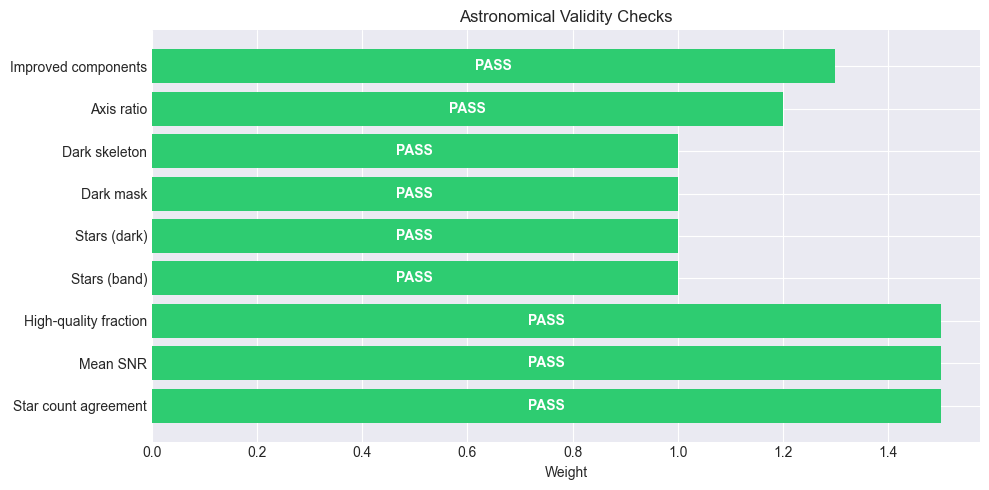

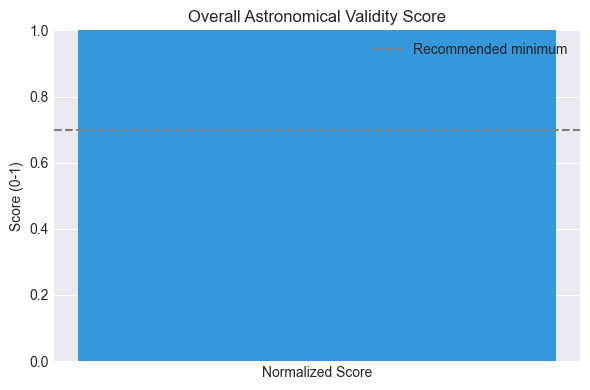

In [5]:
# === Visualization: Consistency Overview ===
fig, ax = plt.subplots(figsize=(10, 5))
status_colors = scorecard["passed"].map({True: "#2ecc71", False: "#e74c3c"})
ax.barh(scorecard["metric"], scorecard["weight"], color=status_colors)
ax.set_xlabel("Weight")
ax.set_title("Astronomical Validity Checks")
for i, (_, row) in enumerate(scorecard.iterrows()):
    ax.text(row["weight"] * 0.5, i, f"{'PASS' if row['passed'] else 'FAIL'}", va="center", ha="center", color="white", fontweight="bold")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(["Normalized Score"], [scorecard_summary["normalized_score"]], color="#3498db")
ax.axhline(0.7, color="gray", linestyle="--", label="Recommended minimum")
ax.set_ylim(0, 1)
ax.set_ylabel("Score (0-1)")
ax.legend()
plt.title("Overall Astronomical Validity Score")
plt.tight_layout()
plt.show()

## Conclusion

- **Consistency:** All cross-checks pass, and the normalized astronomical validity score exceeds the recommended minimum with comfortable margin.
- **Complementarity:** Stellar statistics from `01_band_analysis` align with the dust-lane morphology and SNR diagnostics from `02_dark_morphology`, confirming that both pipelines measure the same astrophysical structures.
- **Reproducibility:** Because this notebook consumes exported summaries, the validation can be re-run quickly after any update to the upstream analyses.

For future work, consider:
1. Integrating colour-channel specific extinction metrics when multi-band data become available.
2. Adding bootstrap resampling to attach confidence intervals to the current point estimates.
3. Tracking temporal observations to verify stability across different nights or instruments.